##Titanic Survival Prediction Project

##Done By: Ashwath Bala S

Table of Contents

1.Problem Statement

2.Data Dictionary

3.Importing the Required Libraries

4.Loading the Dataset

5.Exploratory Data Analysis

6.Missing Value Treatment

7.Feature Engineering

8.Model Building

9.Model Testing

##1. Problem Statement
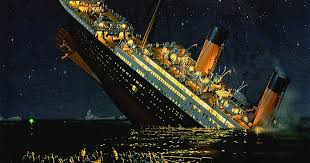

The objective of this project is to develop machine learning model that can predict the likelihood of survival of passengers on the Titanic based on various features such as age, gender, passenger class and other relevant attributes.

##2.Data Dictionary

We have a separate train and test set, in which test set is without the Target Variable and we will be using it for Model Testing

We will be having the following columns:

PassengerId - A unique identifier for each passenger.

Survived - Survival indicator (0 = No, 1 = Yes) [Target Variable].

Pclass - Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd).

Name - Name of the passenger.

Sex - Sex of the passenger.

Age - Age of the passenger.

SibSp - Number of siblings/spouses aboard the Titanic.

Parch - Number of parents/children aboard the Titanic.

Ticket - Ticket number.

Fare - Passenger fare.

Cabin - Cabin number.

Embarked - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

##3.Importing the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

##4.Loading the Dataset

In [2]:
train_data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

##5.Exploratory Data Analysis

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_num = train_data[["Age", "SibSp", "Parch", "Fare"]]
df_cat = train_data[["Survived", "Sex", "Cabin", "Embarked", "Ticket"]]

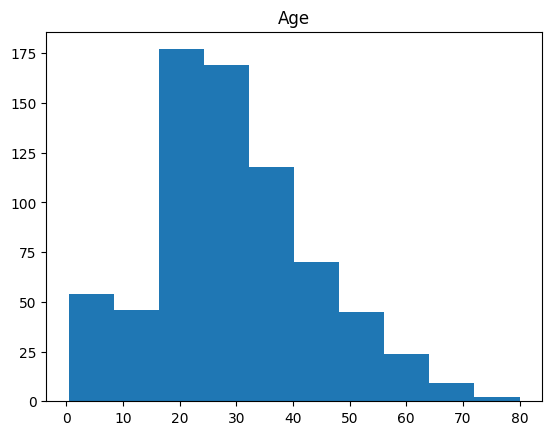

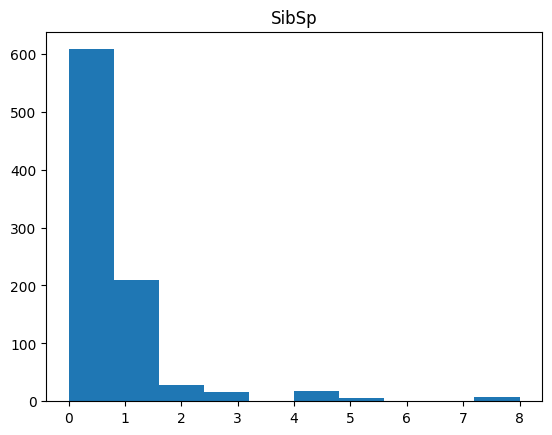

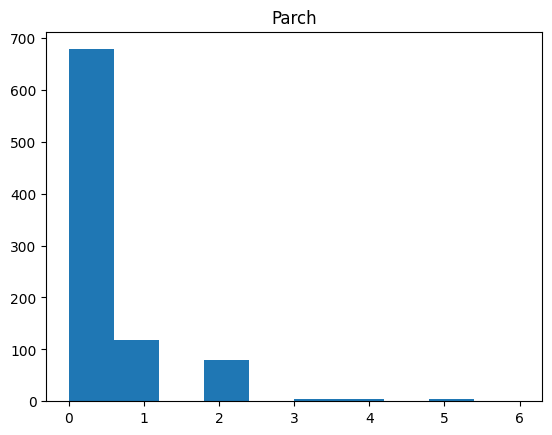

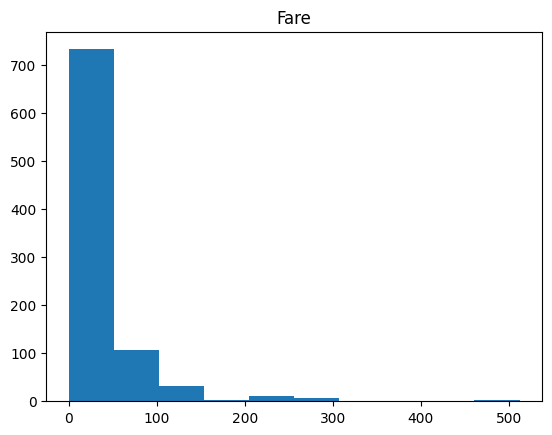

In [5]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

<Axes: xlabel='Pclass', ylabel='Fare'>

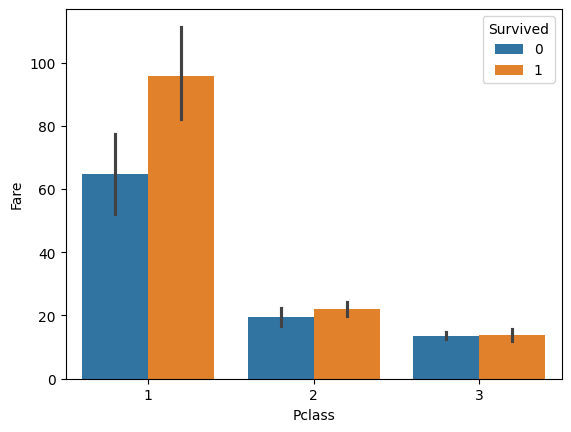

In [6]:
sns.barplot(data=train_data, x="Pclass", y="Fare", hue="Survived")

In [7]:
pd.pivot_table(train_data, index="Survived", values=["Age", "SibSp", "Parch", "Fare"])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


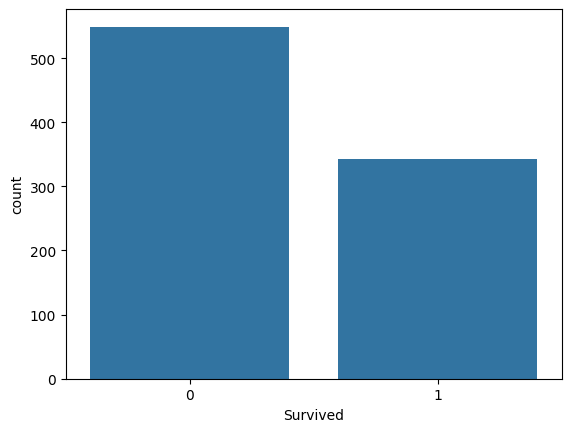

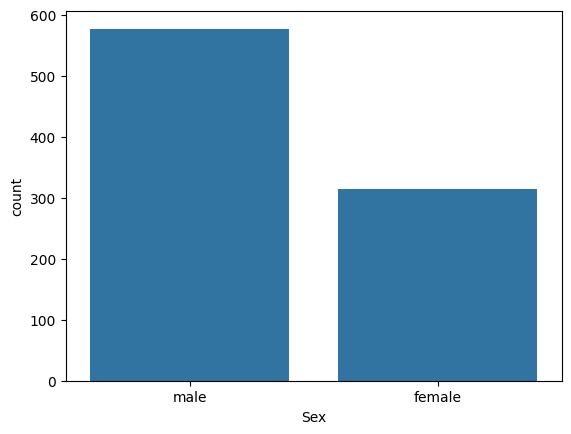

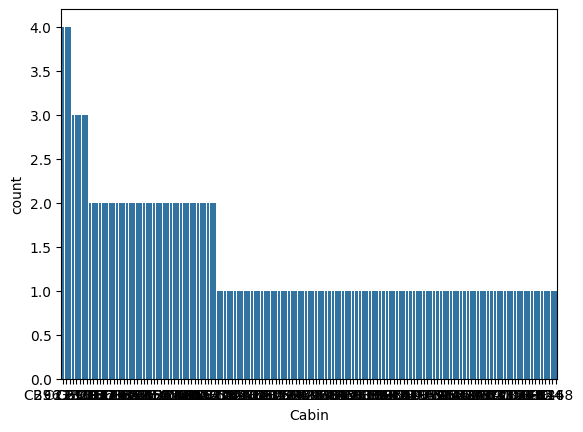

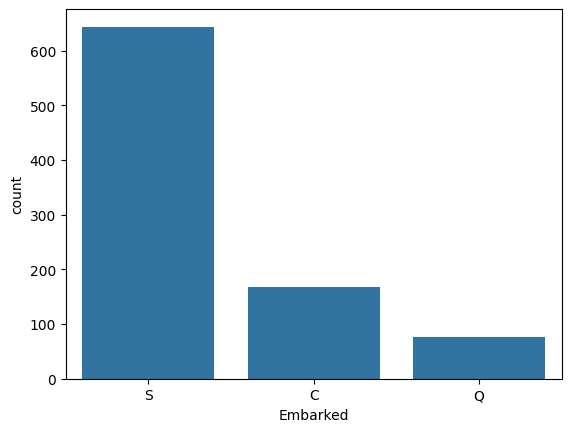

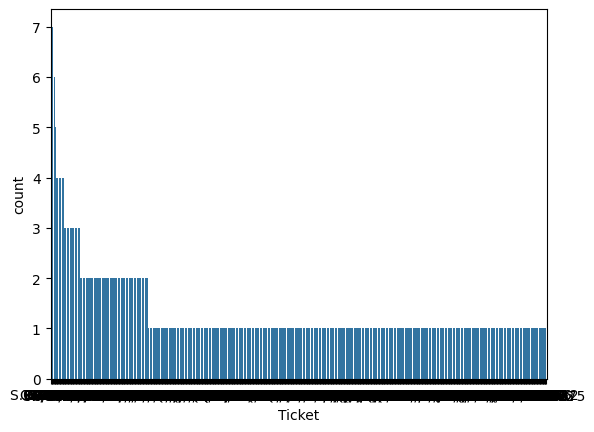

In [8]:
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index, y=df_cat[i].value_counts())
    plt.show()

<Axes: >

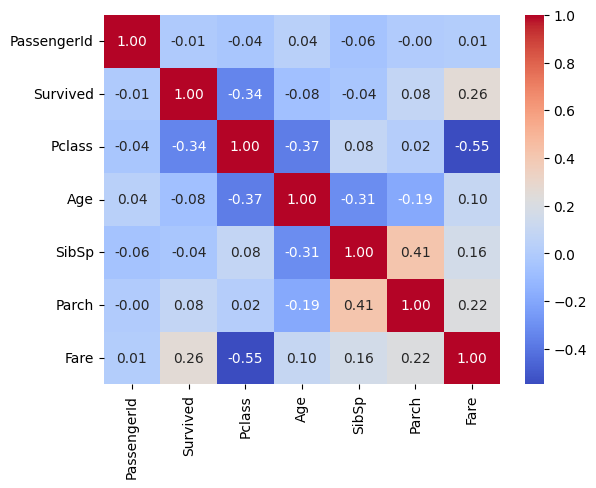

In [9]:
corr = train_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

In [10]:
x = pd.DataFrame(
    (
        pd.pivot_table(
            train_data,
            index="Survived",
            columns="Sex",
            values="Ticket",
            aggfunc="count",
        )
    )
)
print()
print(
    pd.pivot_table(
        train_data, index="Survived", columns="Pclass", values="Ticket", aggfunc="count"
    )
)
print()
print(
    pd.pivot_table(
        train_data,
        index="Survived",
        columns="Embarked",
        values="Ticket",
        aggfunc="count",
    )
)
print()
x


Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217



Sex,female,male
Survived,,
0,81,468
1,233,109


##6.Missing Value Treatment

In [11]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].mean())

In [13]:
train_data["Embarked"] = train_data["Embarked"].fillna(train_data["Embarked"].mode()[0])

We can drop the columns that won't be required for our model building

In [14]:
train_data = train_data.drop(columns=["PassengerId", "Cabin", "Name", "Ticket"])

In [15]:
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

##7. Feature Engineering

In [16]:
train_data["Fare"] = np.log(train_data["Fare"] + 1)

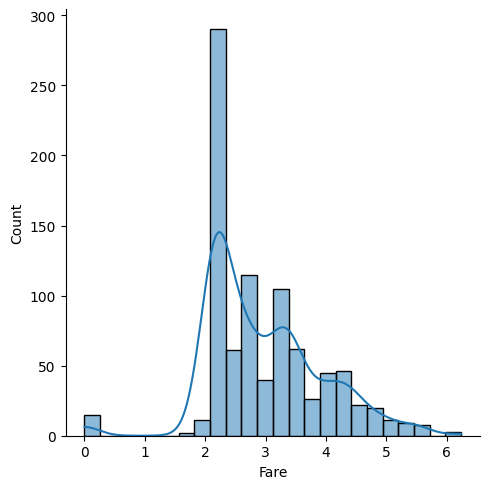

In [17]:
sns.displot(train_data["Fare"], kde=True)

In [18]:
cols = ["Sex", "Embarked"]
le = LabelEncoder()
for col in cols:
    train_data[col] = le.fit_transform(train_data[col])

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,2.110213,2
1,1,1,0,38.0,1,0,4.280593,0
2,1,3,0,26.0,0,0,2.188856,2
3,1,1,0,35.0,1,0,3.990834,2
4,0,3,1,35.0,0,0,2.202765,2


##8. Model Building

In [19]:
# Split the data into features (X) and target (y)
X = train_data.drop(columns=["Survived"], axis=1)
y = train_data["Survived"]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

##Logistic Regression Model

In [20]:
# Initializing the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Training the model
logreg.fit(x_train, y_train)

# Predicting on the test set and calculate accuracy
accuracy_logreg = logreg.score(x_test, y_test)

# Performing cross-validation
cv_scores = cross_val_score(logreg, X, y, cv=5)
mean_cv_score_logreg = np.mean(cv_scores)

# Printing accuracy and cross-validation score
print("Accuracy:", accuracy_logreg)
print("Mean CV Score:", mean_cv_score_logreg)

Accuracy: 0.8116591928251121
Mean CV Score: 0.7833971502102819


##Decision Tree Classifier Model

In [21]:
# Initializing the Decision Tree Classifier model
decision_tree = DecisionTreeClassifier(random_state=40)

# Training the model
decision_tree.fit(x_train, y_train)

# Predicting on the test set and calculate accuracy
accuracy_decision_tree = decision_tree.score(x_test, y_test)

# Performing cross-validation
cv_scores = cross_val_score(decision_tree, X, y, cv=5)
mean_cv_score_decision_tree = np.mean(cv_scores)

# Printing accuracy and cross-validation score
print("Accuracy:", accuracy_decision_tree)
print("Mean CV Score:", mean_cv_score_decision_tree)

Accuracy: 0.7713004484304933
Mean CV Score: 0.776686962525893


Light Gradient Boosting Machine (LightGBM) Model

In [22]:
# Initializing the LGBMClassifier model
lgbm = LGBMClassifier(random_state=40)

# Training the model
lgbm.fit(x_train, y_train)

# Predicting on the test set and calculate accuracy
accuracy_lgbm = lgbm.score(x_test, y_test)

# Performing cross-validation
cv_scores = cross_val_score(lgbm, X, y, cv=5)
mean_cv_score_lgbm = np.mean(cv_scores)

# Printing accuracy and cross-validation score
print("Accuracy:", accuracy_lgbm)
print("Mean CV Score:", mean_cv_score_lgbm)

[LightGBM] [Info] Number of positive: 247, number of negative: 421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369760 -> initscore=-0.533244
[LightGBM] [Info] Start training from score -0.533244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


##XGBoost Model

In [23]:
# Initializing the XGBClassifier model
xgb = XGBClassifier(random_state=40)

# Training the model
xgb.fit(x_train, y_train)

# Predicting on the test set and calculate accuracy
accuracy_xgb = xgb.score(x_test, y_test)

# Performing cross-validation
cv_scores = cross_val_score(xgb, X, y, cv=5)
mean_cv_score_xgb = np.mean(cv_scores)

# Printing accuracy and cross-validation score
print("Accuracy:", accuracy_xgb)
print("Mean CV Score:", mean_cv_score_xgb)

Accuracy: 0.8161434977578476
Mean CV Score: 0.8148327160881301


##Extra Tree Classifier Model

In [24]:
# Initializing the ExtraTreesClassifier model
extra_trees = ExtraTreesClassifier(random_state=40)

# Training the model
extra_trees.fit(x_train, y_train)

# Predicting on the test set and calculate accuracy
accuracy_extra_trees = extra_trees.score(x_test, y_test)

# Performing cross-validation
cv_scores = cross_val_score(extra_trees, X, y, cv=5)
mean_cv_score_extra_trees = np.mean(cv_scores)

# Printing accuracy and cross-validation score
print("Accuracy:", accuracy_extra_trees)
print("Mean CV Score:", mean_cv_score_extra_trees)

Accuracy: 0.7982062780269058
Mean CV Score: 0.789033958947963


Model Comparision

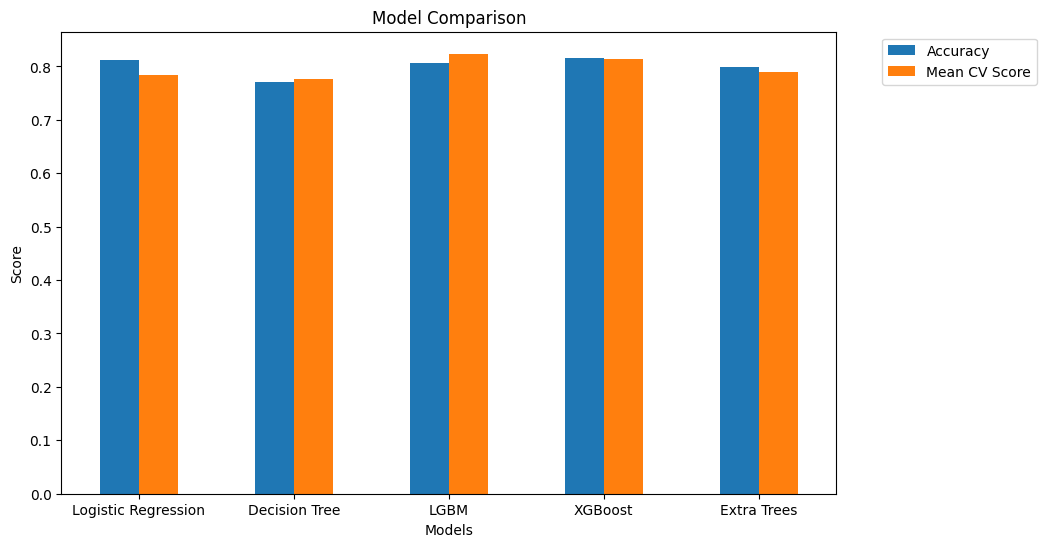

In [25]:
# Creating lists to store the scores for each model
accuracy_scores = []
mean_cv_scores = []

# Appending scores for each model
accuracy_scores.append(accuracy_logreg)
mean_cv_scores.append(mean_cv_score_logreg)

accuracy_scores.append(accuracy_decision_tree)
mean_cv_scores.append(mean_cv_score_decision_tree)

accuracy_scores.append(accuracy_lgbm)
mean_cv_scores.append(mean_cv_score_lgbm)

accuracy_scores.append(accuracy_xgb)
mean_cv_scores.append(mean_cv_score_xgb)

accuracy_scores.append(accuracy_extra_trees)
mean_cv_scores.append(mean_cv_score_extra_trees)

# Creating a DataFrame with the scores
results_df = pd.DataFrame({
    'Accuracy': accuracy_scores,
    'Mean CV Score': mean_cv_scores
}, index=['Logistic Regression', 'Decision Tree', 'LGBM', 'XGBoost', 'Extra Trees'])

# Plotting the results
results_df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [26]:
# Finding the index of the model with the highest accuracy
best_accuracy_index = results_df['Accuracy'].idxmax()

# Finding the index of the model with the highest mean cross-validation score
best_cv_index = results_df['Mean CV Score'].idxmax()

# Determining the best model based on both criteria
best_model_accuracy = results_df.loc[best_accuracy_index]
best_model_cv = results_df.loc[best_cv_index]

# Printing the best model based on accuracy
print("Best Model based on Accuracy:")
print(best_model_accuracy)

# Printing the best model based on mean cross-validation score
print("\nBest Model based on Mean Cross-Validation Score:")
print(best_model_cv)

Best Model based on Accuracy:
Accuracy         0.816143
Mean CV Score    0.814833
Name: XGBoost, dtype: float64

Best Model based on Mean Cross-Validation Score:
Accuracy         0.807175
Mean CV Score    0.823828
Name: LGBM, dtype: float64


We can see both from the graph and the above code, LightGBM Model is performing better, when compared to other models.

Cross-validation provides a more reliable estimate of a model's performance on unseen data. Therefore, we will prioritize cross-validation scores for model selection and use accuracy as a supplementary metric for interpretation

##9. Model Testing

In [27]:
# For Test Dataset

X_test = test.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"], axis=1)

X_test["Age"] = X_test["Age"].fillna(X_test["Age"].mean())
X_test["Fare"] = X_test["Fare"].fillna(X_test["Fare"].mean())

X_test.isnull().sum()

from sklearn.preprocessing import LabelEncoder

cols = ["Sex", "Embarked"]
le = LabelEncoder()

for col in cols:
    X_test[col] = le.fit_transform(X_test[col])

X_test.head()
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.50000,0,0,7.8292,1
1,3,0,47.00000,1,0,7.0000,2
2,2,1,62.00000,0,0,9.6875,1
3,3,1,27.00000,0,0,8.6625,2
4,3,0,22.00000,1,1,12.2875,2
...,...,...,...,...,...,...,...
413,3,1,30.27259,0,0,8.0500,2
414,1,0,39.00000,0,0,108.9000,0
415,3,1,38.50000,0,0,7.2500,2
416,3,1,30.27259,0,0,8.0500,2


In [28]:
# Making predictions on the test set
predictions_lgbm = lgbm.predict(x_test)
predictions_lgbm

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1])

In [29]:
# Accuracy on the test set
accuracy_test_lgbm = accuracy_score(y_test, predictions_lgbm)

# Cross-validation on the test set (using the same folds as before)
cv_scores_test_lgbm = cross_val_score(lgbm, x_test, y_test, cv=5)
mean_cv_score_test_lgbm = np.mean(cv_scores_test_lgbm)

# Printing accuracy and cross-validation score for the test set
print("Accuracy on Test Set:", accuracy_test_lgbm)
print("Mean CV Score on Test Set:", mean_cv_score_test_lgbm)

[LightGBM] [Info] Number of positive: 76, number of negative: 102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426966 -> initscore=-0.294239
[LightGBM] [Info] Start training from score -0.294239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

We can conclude that the model is performing well in our Test set too.

##In this Project, we have predicted the Titanic Survival using Machine Learning Techniques